# Prediction Insights

## Overview

Howso Engine enables powerful predictions with complete attribution and detailed explanations to make learning from
and debugging your data and predictions as easy as possible. For more information on predictions with Howso Engine,
check out the [predictions user guide](https://docs.howso.com/en/release-latest/user_guide/basic_capabilities/predictions.html).

In [1]:
from pprint import pprint

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

## Setup

This recipe will focus on the insights gained from predictions. Specifically, insights from:

- Influential Cases,
- Feature Contributions,
- Residual and Similarity Conviction,
- and Categorical Action Probabilities.

The [basic workflow guide](https://docs.howso.com/en/release-latest/user_guide/basic_capabilities/basic_workflow.html) covers creating a Trainee and performing a basic react in detail.

### Load Data and Create Trainee

In [2]:
df = pd.read_csv("../../data/iris/iris.tsv.gz", sep="\t", compression="gzip")
train_data = df.iloc[:-30]
new_data = df[~df.index.isin(train_data.index)]
features = infer_feature_attributes(train_data)

t = Trainee(features=features)

df

,Unnamed: 0,sepal length,sepal width,petal length,petal width,class
0,27,5.2,3.5,1.5,0.2,Iris-setosa
1,14,5.8,4.0,1.2,0.2,Iris-setosa
2,25,5.0,3.0,1.6,0.2,Iris-setosa
3,82,5.8,2.7,3.9,1.2,Iris-versicolor
4,97,6.2,2.9,4.3,1.3,Iris-versicolor
...,...,...,...,...,...,...
145,126,6.2,2.8,4.8,1.8,Iris-virginica
146,124,6.7,3.3,5.7,2.1,Iris-virginica
147,78,6.0,2.9,4.5,1.5,Iris-versicolor
148,125,7.2,3.2,6.0,1.8,Iris-virginica


### Train, Analyze, and React

In [3]:
t.train(train_data)
t.analyze()
t.react_into_features(similarity_conviction=True)

reaction = t.react(
    contexts=new_data,
    context_features=["sepal length", "sepal width", "petal length", "petal width"],
    action_features=["class"],
    details={
        "influential_cases": True,
        "similarity_conviction": True,
        "feature_robust_prediction_contributions": True,
        "feature_robust_residuals": True,
        "feature_full_residual_convictions_for_case": True,
        "categorical_action_probabilities": True,
    }
)

Note that, unlike in the basic workflow guide, we include several `details` in the react call and predict multiple cases as opposed to one. These are what will enable the
insights that we're going to get after the predictions are made.

For more information, see [the API documentation for `Trainee.react()`](https://docs.howso.com/en/release-latest/api_reference/_autosummary/howso.engine.html#howso.engine.Trainee.react).

### Inspect the Predictions

Howso Engine has high accuracy even on small datasets.

Here we see a comparison of the trained data (dots) and the predicted data (stars). This plot shows that the predictions align well with the trained data.

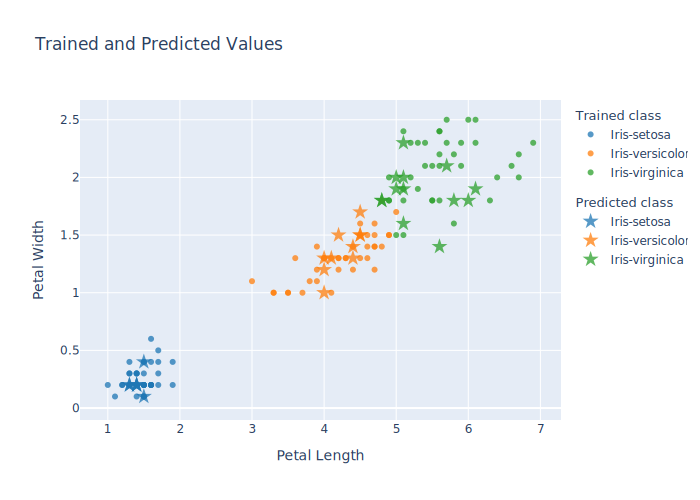

In [ ]:
train_data = train_data.astype({"class": str})
predicted_data = pd.concat([new_data.reset_index(drop=True).drop(columns="class"), reaction["action"]], axis=1)
predicted_data = predicted_data.astype({"class": str})

cmap = px.colors.qualitative.D3
fig = go.Figure()
for i, (label, group) in enumerate(train_data.groupby("class")):
    fig.add_trace(go.Scatter(
        x=group["petal length"],
        y=group["petal width"],
        mode="markers",
        name=label,
        marker=dict(color=cmap[i], opacity=0.75),
        legendgroup="trained",
        legendgrouptitle_text="Trained class",
    ))

for i, (label, group) in enumerate(predicted_data.groupby("class")):
    fig.add_trace(go.Scatter(
        x=group["petal length"],
        y=group["petal width"],
        mode="markers",
        marker=dict(size=12, symbol="star", color=cmap[i], opacity=0.75),
        name=label,
        legendgroup="predicted",
        legendgrouptitle_text="Predicted class",
        hovertext=group.index,
    ))

fig.update_layout(
    xaxis_title="Petal Length",
    yaxis_title="Petal Width",
    title="Trained and Predicted Values"
)
fig.show(width=1000)

For categorical action features, the prediction can be further understood with the `categorical_action_probabilities` detail.  
This shows the probability of each possible value of the target feature. This information can highlight cases that are on the
border of two classes, like some of the above points are.  The closer a case gets to a class border, the more mixed the
categorical action probabilities may get.

In [5]:
pprint(reaction["details"]["categorical_action_probabilities"], compact=True)

[{'class': {'Iris-versicolor': 1}},
 {'class': {'Iris-versicolor': 0.14480918105033755,
            'Iris-virginica': 0.8551908189496624}},
 {'class': {'Iris-virginica': 1}},
 {'class': {'Iris-versicolor': 0.06829409233979566,
            'Iris-virginica': 0.9317059076602044}},
 {'class': {'Iris-versicolor': 0.07307615800120393,
            'Iris-virginica': 0.9269238419987961}},
 {'class': {'Iris-versicolor': 1}}, {'class': {'Iris-setosa': 1}},
 {'class': {'Iris-versicolor': 0.0877523247296279,
            'Iris-virginica': 0.9122476752703721}},
 {'class': {'Iris-versicolor': 1}}, {'class': {'Iris-versicolor': 1}},
 {'class': {'Iris-versicolor': 0.06275769503104892,
            'Iris-virginica': 0.9372423049689511}},
 {'class': {'Iris-versicolor': 1}}, {'class': {'Iris-setosa': 1}},
 {'class': {'Iris-versicolor': 0.20858685138999727,
            'Iris-virginica': 0.7914131486100028}},
 {'class': {'Iris-versicolor': 1}}, {'class': {'Iris-setosa': 1}},
 {'class': {'Iris-setosa': 1}},
 {

For example, if we look at case `4`, we see a mix of probabilities because this case is on the border of two classes.

In [6]:
reaction["details"]["categorical_action_probabilities"][4]

{'class': {'Iris-virginica': 0.9269238419987961,
  'Iris-versicolor': 0.07307615800120393}}

### Insight 1: Which Cases Contributed?

Howso provides complete attribution for any and all predictions, showing exactly which cases influenced each prediction.  This can be used to understand or debug predictions.  For instance,
we can inspect the influential cases for one of the cases (case `4`) that was on the decision boundary in the plot above.  We can see that there is a mix of class values and no cases stand
out in terms of influence weight:

In [7]:
inf_cases_4 = pd.DataFrame(reaction["details"]["influential_cases"][4])
inf_cases_4

,petal length,.influence_weight,.session_training_index,sepal length,petal width,class,sepal width,.session
0,5.6,0.235961,61,6.3,1.8,Iris-virginica,2.9,83079769-b8ac-413d-9cfc-54d51f60878a
1,5.1,0.153706,99,6.3,1.5,Iris-virginica,2.8,83079769-b8ac-413d-9cfc-54d51f60878a
2,5.5,0.133429,6,6.4,1.8,Iris-virginica,3.1,83079769-b8ac-413d-9cfc-54d51f60878a
3,5.5,0.127010,66,6.5,1.8,Iris-virginica,3.0,83079769-b8ac-413d-9cfc-54d51f60878a
4,5.0,0.088775,34,6.0,1.5,Iris-virginica,2.2,83079769-b8ac-413d-9cfc-54d51f60878a
5,5.3,0.074724,103,6.4,1.9,Iris-virginica,2.7,83079769-b8ac-413d-9cfc-54d51f60878a
6,4.9,0.073076,107,6.3,1.5,Iris-versicolor,2.5,83079769-b8ac-413d-9cfc-54d51f60878a
7,5.6,0.065847,36,6.4,2.1,Iris-virginica,2.8,83079769-b8ac-413d-9cfc-54d51f60878a
8,5.8,0.047473,42,7.2,1.6,Iris-virginica,3.0,83079769-b8ac-413d-9cfc-54d51f60878a


Compare that to the influential cases for case `20`, which is firmly in the center of the solo cluster.  Here we see a single class value.

In [8]:
inf_cases_20 = pd.DataFrame(reaction["details"]["influential_cases"][20])
inf_cases_20

,petal length,.influence_weight,.session_training_index,sepal length,petal width,class,sepal width,.session
0,1.5,0.079413,117,5.1,0.4,Iris-setosa,3.7,83079769-b8ac-413d-9cfc-54d51f60878a
1,1.5,0.077311,0,5.2,0.2,Iris-setosa,3.5,83079769-b8ac-413d-9cfc-54d51f60878a
2,1.4,0.077146,48,5.1,0.3,Iris-setosa,3.5,83079769-b8ac-413d-9cfc-54d51f60878a
3,1.6,0.074531,63,5.0,0.4,Iris-setosa,3.4,83079769-b8ac-413d-9cfc-54d51f60878a
4,1.5,0.074403,104,5.4,0.2,Iris-setosa,3.7,83079769-b8ac-413d-9cfc-54d51f60878a
5,1.4,0.070970,43,5.2,0.2,Iris-setosa,3.4,83079769-b8ac-413d-9cfc-54d51f60878a
6,1.5,0.070824,68,5.3,0.2,Iris-setosa,3.7,83079769-b8ac-413d-9cfc-54d51f60878a
7,1.5,0.067658,85,5.1,0.2,Iris-setosa,3.4,83079769-b8ac-413d-9cfc-54d51f60878a
8,1.7,0.063075,9,5.4,0.2,Iris-setosa,3.4,83079769-b8ac-413d-9cfc-54d51f60878a
9,1.5,0.061431,39,5.1,0.3,Iris-setosa,3.8,83079769-b8ac-413d-9cfc-54d51f60878a


With the influential cases we can derive additional insights, such as identifying anomalous cases from within the influential cases using `similarity_conviction`.  
This can help to identify data that are making predictions more noisy or identify what type of data should be collected to improve predictive power in the future.

In [9]:
inf_case_indices = inf_cases_4[[".session", ".session_training_index"]].values.tolist()

anom_df = t.get_cases(
    case_indices=inf_case_indices,
    features=["sepal length", "sepal width", "petal length", "petal width", "class", "similarity_conviction"]
)

anom_df.sort_values(by="similarity_conviction")

,sepal length,sepal width,petal length,petal width,class,similarity_conviction
4,6.0,2.2,5.0,1.5,Iris-virginica,0.667409
8,7.2,3.0,5.8,1.6,Iris-virginica,0.687374
1,6.3,2.8,5.1,1.5,Iris-virginica,0.889083
0,6.3,2.9,5.6,1.8,Iris-virginica,0.940266
6,6.3,2.5,4.9,1.5,Iris-versicolor,0.960215
7,6.4,2.8,5.6,2.1,Iris-virginica,1.088268
5,6.4,2.7,5.3,1.9,Iris-virginica,1.217579
2,6.4,3.1,5.5,1.8,Iris-virginica,1.217696
3,6.5,3.0,5.5,1.8,Iris-virginica,1.240963


In [10]:
inf_case_indices = inf_cases_20[[".session", ".session_training_index"]].values.tolist()

anom_df = t.get_cases(
    case_indices=inf_case_indices,
    features=["sepal length", "sepal width", "petal length", "petal width", "class", "similarity_conviction"],
)

anom_df.sort_values(by="similarity_conviction")

,sepal length,sepal width,petal length,petal width,class,similarity_conviction
12,5.4,3.9,1.7,0.4,Iris-setosa,0.642619
6,5.3,3.7,1.5,0.2,Iris-setosa,0.797688
10,5.1,3.5,1.4,0.2,Iris-setosa,0.813224
4,5.4,3.7,1.5,0.2,Iris-setosa,0.849347
8,5.4,3.4,1.7,0.2,Iris-setosa,1.020849
13,5.4,3.9,1.3,0.4,Iris-setosa,1.104164
2,5.1,3.5,1.4,0.3,Iris-setosa,1.168749
11,5.1,3.3,1.7,0.5,Iris-setosa,1.200333
7,5.1,3.4,1.5,0.2,Iris-setosa,1.218001
14,5.0,3.4,1.5,0.2,Iris-setosa,1.336226


### Insight 2: Which Features Contributed?

In addition to providing attribution to cases, Howso also provides robust feature contributions to explain which features contributed to each prediction.
When inspecting the feature importances for case `13`,  we see that `petal width` and `petal length` provided the majority of the contribution to the 
prediction, whereas for case `20` `petal width` and `petal length` only have slightly higher contributions than the other features.  This could indicate 
that different features are more important for predicting different classes within this dataset and that focusing on those features would be prudent.

Identifying that certain cases that influenced a prediction are anomalous can help to explain low predictive power in certain parts of the data or other
issues that may appear during deployment.

In [11]:
fcs_13 = pd.DataFrame(reaction["details"]["feature_robust_prediction_contributions"][13:14], index=[13])
fcs_20 = pd.DataFrame(reaction["details"]["feature_robust_prediction_contributions"][20:21], index=[20])

display(fcs_13)
display(fcs_20)

,petal length,sepal length,petal width,sepal width
13,0.306495,0.073063,0.308541,0.01152


,petal length,sepal length,petal width,sepal width
20,0.16004,0.081697,0.161058,0.08073


### Insight 3: How Certain is the Prediction?

[Residuals](https://docs.howso.com/en/release-latest/user_guide/basic_capabilities/residuals.html) can characterize the uncertainty of the data around the prediction.  This will tell us which features are hard to predict in the region of the data around each case we're predicting.
If a prediction is less accurate than expected, this can explain which features were noisy and may have contributed to the problem.

In [12]:
pd.DataFrame(reaction["details"]["feature_robust_prediction_contributions"])

,petal length,sepal length,petal width,sepal width
0,0.357763,0.063648,0.299820,0.034680
1,0.195765,0.046332,0.257863,0.016326
2,0.229563,0.045148,0.296979,0.021235
3,0.231714,0.067127,0.309239,0.062385
4,0.304537,0.046876,0.231901,0.022330
5,0.221868,0.054993,0.224927,0.022174
6,0.207883,0.160502,0.207246,0.023320
7,0.203872,0.100765,0.204834,0.035907
8,0.315612,0.037694,0.231940,0.022540
9,0.190268,0.044208,0.195633,0.068019


We can also use [`residual conviction`](https://docs.howso.com/en/release-latest/user_guide/basic_capabilities/conviction.html#prediction-residual-conviction) to determine which features
are uncertain in a scale-invariant manner, which can be useful if you wish to compare different features of different scales against each other.  Higher residual conviction
indicates something that is less surprising than expected and lower redsidual conviction indicates the opposite.

In [13]:
pd.DataFrame(reaction["details"]["feature_full_residual_convictions_for_case"])

,petal length,sepal length,petal width,class,sepal width
0,0.739860,0.602208,1.271804,8.140029,1.305773
1,0.725392,0.918516,1.833580,1.077276,0.442836
2,0.489154,0.376043,0.732240,5.969390,1.538310
3,1.510401,0.923586,1.449805,2.227736,0.712332
4,0.456984,0.701504,0.345404,2.084810,0.934200
5,2.079409,1.421895,1.088780,2.410885,0.713646
6,1.130625,1.337047,1.195611,1.000000,0.972561
7,0.706391,0.739773,1.608880,1.303443,0.657132
8,1.558807,0.999248,1.032057,5.531712,0.442418
9,1.674463,1.293919,1.022346,2.786337,0.540003


### Insight 4: How Anomalous are the Predicted Cases?

By getting the [`similarity conviction`](https://docs.howso.com/en/release-latest/user_guide/basic_capabilities/conviction.html#similarity-conviction) of the cases that we predict, 
we can determine which of them are anomalous relative to the trained data. This could help to highlight cases that are unusually difficult or easy to predict, such as can be the case
when model drift occurs as a form of model monitoring.

In [14]:
pprint(reaction["details"]["similarity_conviction"], compact=True)

[4.186986004926596, 2.7378619236806014, 2.9297627660634236, 2.5888658748416944,
 1.3610424607508746, 5.41547162177084, 5.970348518749878, 2.946739135170023,
 1.6096043115538217, 3.381334667696927, 5.636590269126615, 2.3809685134753518,
 11.21961373492701, 2.9940194914953935, 2.536781525947101, 3.358736446495446,
 2.1502838481123945, 3.861985421969387, 1.502662635177957, 0.782374638289009,
 2.032800693869961, 4.982774012727669, 1.5367161148686022, 4.351923224552732,
 3.773756782840577, 3.70261626260516, 3.3929498262839104, 3.6176923094213675,
 2.256670565597702, 2.374021122842651]


In this case, there are no cases with a low similarity_conviction which indicates that there are no cases that we reacted to which are particularly
anomalous.